# Imports

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#model`s stuff
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose # identify seasonal component
import pmdarima as pm
import pickle

# DataFrame formation

In [2]:
gvs_time_series = pd.read_excel("–ü–æ—Å—É—Ç–æ—á–Ω–∞—è –≤–µ–¥–æ–º–æ—Å—Ç—å –û–î–ü–£ –ì–í–°.xlsx", header=0)
hvs_time_series = pd.read_excel("–ü–æ—Å—É—Ç–æ—á–Ω–∞—è –≤–µ–¥–æ–º–æ—Å—Ç—å –≤–æ–¥–æ—Å—á–µ—Ç—á–∏–∫–∞ –•–í–° –ò–¢–ü.xlsx", header=0)

In [3]:
gvs_time_series

–î–∞—Ç–∞ –í—Ä–µ–º—è —Å—É—Ç–æ–∫, —á  –ü–æ–¥–∞—á–∞, –º3  –û–±—Ä–∞—Ç–∫–∞, –º3  \
0             01.04.2025            0-1        0.23         0.12   
1             01.04.2025            1-2        0.09         0.05   
2             01.04.2025            2-3        0.11         0.06   
3             01.04.2025            3-4        0.11         0.06   
4             01.04.2025            4-5        0.14         0.08   
..                   ...            ...         ...          ...   
715  2025-04-30 00:00:00          19-20        0.00         0.00   
716  2025-04-30 00:00:00          20-21        0.00         0.00   
717  2025-04-30 00:00:00          21-22        0.00         0.00   
718  2025-04-30 00:00:00          22-23        0.00         0.00   
719  2025-04-30 00:00:00          23-24        0.00         0.00   

     –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3  –¢1 –≥–≤—Å, –æ–°  –¢2 –≥–≤—Å, –æ–°  
0                         0.11          60          42  
1                         0.04          60          42  
2                         0.05          60          42  
3                         0.05          60          42  
4                         0.06          60          42  
..                         ...         ...         ...  
715                       0.00          48          27  
716                       0.00          48          27  
717                       0.00          48          27  
718                       0.00          48          27  
719                       0.00          48          27  

[720 rows x 7 columns]

In [4]:
hvs_time_series = hvs_time_series.rename(columns={'–ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3': '–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3'})
gvs_time_series = pd.concat([gvs_time_series, hvs_time_series[['–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3']]], axis=1) # —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ —Å–æ –≤—Å–µ–º–∞–∏ –ø–æ–∫–∞–∑–∞–Ω–∏—è–º–∏

In [5]:
gvs_time_series['–î–∞—Ç–∞'] = pd.to_datetime(gvs_time_series['–î–∞—Ç–∞'], format='%d.%m.%Y', errors='coerce')

hour = gvs_time_series['–í—Ä–µ–º—è —Å—É—Ç–æ–∫, —á'].str.split('-').str[0].astype(int)

gvs_time_series['–ú–µ—Ç–∫–∞ –≤—Ä–µ–º–µ–Ω–∏'] = gvs_time_series['–î–∞—Ç–∞'] + pd.to_timedelta(hour, unit='h')#  –ø–æ–ª—É—á–µ–Ω–∏–µ –º–µ—Ç–∫–∏ –≤—Ä–µ–º–µ–Ω–∏(–≤ excel –æ–Ω–æ –Ω–µ–∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ–µ)

In [6]:
print(gvs_time_series.isnull().sum())# –ø—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ null

–î–∞—Ç–∞                             0
–í—Ä–µ–º—è —Å—É—Ç–æ–∫, —á                   0
–ü–æ–¥–∞—á–∞, –º3                       0
–û–±—Ä–∞—Ç–∫–∞, –º3                      0
–ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3        0
–¢1 –≥–≤—Å, –æ–°                       0
–¢2 –≥–≤—Å, –æ–°                       0
–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3    0
–ú–µ—Ç–∫–∞ –≤—Ä–µ–º–µ–Ω–∏                    0
dtype: int64


In [7]:
gvs_time_series.set_index('–ú–µ—Ç–∫–∞ –≤—Ä–µ–º–µ–Ω–∏', inplace=True)# —É—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º –∏–Ω–¥–µ–∫—Å –Ω–∞ –º–µ—Ç–∫—É –≤—Ä–µ–º–µ–Ω–∏
gvs_time_series = gvs_time_series.loc[:'2025-04-27 00:00:00']# –Ω–µ —É—á–∏—Ç—ã–≤–∞–µ–º –Ω–ª–µ–≤—ã–µ –ø–æ–∫–∞–∑–∞–Ω–∏—è

# Scaling

In [8]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#gvs_time_series[['–ü–æ–¥–∞—á–∞, –º3']] = scaler.fit_transform(gvs_time_series[['–ü–æ–¥–∞—á–∞, –º3']])

In [9]:
# –∏–∑–±–∞–≤–ª—è–µ–º—Å—è –æ—Ç –Ω—É–ª–µ–≤—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
gvs_time_series['–ü–æ–¥–∞—á–∞, –º3'] = gvs_time_series['–ü–æ–¥–∞—á–∞, –º3'].replace(0.00, 0.01)
gvs_time_series['–û–±—Ä–∞—Ç–∫–∞, –º3'] = gvs_time_series['–û–±—Ä–∞—Ç–∫–∞, –º3'].replace(0.00, 0.01)
gvs_time_series['–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3'] = gvs_time_series['–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3'].replace(0.00, 0.01)

# Exogenous variable

In [10]:
gvs_time_series['hour_index'] = gvs_time_series.index.hour # —É–∫–∞–∑—ã–≤–∞–µ–º –∏–Ω–¥–µ–∫—Å —á–∞—Å–∞ –∫–∞–∫ —ç–∫–∑–æ–≥–µ–Ω–Ω—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é

In [11]:
gvs_time_series

–î–∞—Ç–∞ –í—Ä–µ–º—è —Å—É—Ç–æ–∫, —á  –ü–æ–¥–∞—á–∞, –º3  –û–±—Ä–∞—Ç–∫–∞, –º3  \
–ú–µ—Ç–∫–∞ –≤—Ä–µ–º–µ–Ω–∏                                                            
2025-04-01 00:00:00 2025-04-01            0-1        0.23         0.12   
2025-04-01 01:00:00 2025-04-01            1-2        0.09         0.05   
2025-04-01 02:00:00 2025-04-01            2-3        0.11         0.06   
2025-04-01 03:00:00 2025-04-01            3-4        0.11         0.06   
2025-04-01 04:00:00 2025-04-01            4-5        0.14         0.08   
...                        ...            ...         ...          ...   
2025-04-26 20:00:00 2025-04-26          20-21        0.08         0.05   
2025-04-26 21:00:00 2025-04-26          21-22        0.07         0.04   
2025-04-26 22:00:00 2025-04-26          22-23        0.06         0.04   
2025-04-26 23:00:00 2025-04-26          23-24        0.04         0.03   
2025-04-27 00:00:00 2025-04-27            0-1        0.01         0.01   

                     –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3  –¢1 –≥–≤—Å, –æ–°  –¢2 –≥–≤—Å, –æ–°  \
–ú–µ—Ç–∫–∞ –≤—Ä–µ–º–µ–Ω–∏                                                            
2025-04-01 00:00:00                       0.11          60          42   
2025-04-01 01:00:00                       0.04          60          42   
2025-04-01 02:00:00                       0.05          60          42   
2025-04-01 03:00:00                       0.05          60          42   
2025-04-01 04:00:00                       0.06          60          42   
...                                        ...         ...         ...   
2025-04-26 20:00:00                       0.03          52          31   
2025-04-26 21:00:00                       0.03          52          31   
2025-04-26 22:00:00                       0.02          52          31   
2025-04-26 23:00:00                       0.01          52          31   
2025-04-27 00:00:00                       0.00          51          30   

                     –•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3  hour_index  
–ú–µ—Ç–∫–∞ –≤—Ä–µ–º–µ–Ω–∏                                                   
2025-04-01 00:00:00                           0.11           0  
2025-04-01 01:00:00                           0.04           1  
2025-04-01 02:00:00                           0.05           2  
2025-04-01 03:00:00                           0.05           3  
2025-04-01 04:00:00                           0.06           4  
...                                            ...         ...  
2025-04-26 20:00:00                           0.28          20  
2025-04-26 21:00:00                           0.24          21  
2025-04-26 22:00:00                           0.20          22  
2025-04-26 23:00:00                           0.12          23  
2025-04-27 00:00:00                           0.11           0  

[625 rows x 9 columns]

# Identify Seasonal Component

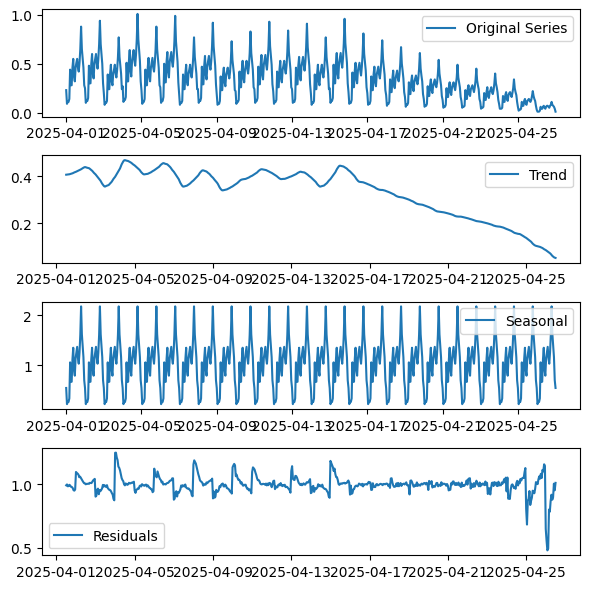

In [12]:
data_type = '–ü–æ–¥–∞—á–∞, –º3'# –∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º —Ç—Ä–µ–Ω–¥—ã –∏ —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç—å –¥–∞–Ω–Ω—ã—Ö
#data_type = '–û–±—Ä–∞—Ç–∫–∞, –º3'
#data_type = '–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3	'

result = seasonal_decompose(gvs_time_series[data_type], model='multiplicative', period=24)# —Ä–∞—Å—Å–∫–ª–∞–¥—ã–≤–∞–µ–º –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã 
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫ —Ä–∞–∑–ª–æ–∂–µ–Ω–Ω—ã—Ö –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–æ–≤
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(gvs_time_series[data_type], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

#  SARIMAX Model Fitting

In [13]:
warnings.filterwarnings("ignore")# –∏–≥–Ω–æ—Ä–∏—Ä—É–µ–º FutureWarnings –∏ –¥—Ä—É–≥–∏–µ –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è

In [28]:
SARIMAX_model = pm.auto_arima(
    gvs_time_series[['–ü–æ–¥–∞—á–∞, –º3']],          # —Ü–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    exogenous=gvs_time_series[['hour_index']], # —ç–∫–∑–æ–≥–µ–Ω–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ
    
    # –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –ù–ï—Å–µ–∑–æ–Ω–Ω–æ–π —á–∞—Å—Ç–∏ –º–æ–¥–µ–ª–∏ (p, d, q)
    start_p=1,  # –Ω–∞—á–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –ø–æ—Ä—è–¥–∫–∞ –∞–≤—Ç–æ—Ä–µ–≥—Ä–µ—Å—Å–∏–∏ (AR) - —Å–∫–æ–ª—å–∫–æ –ø—Ä–æ—à–ª—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å
    start_q=1,  # –Ω–∞—á–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –ø–æ—Ä—è–¥–∫–∞ —Å–∫–æ–ª—å–∑—è—â–µ–≥–æ —Å—Ä–µ–¥–Ω–µ–≥–æ (MA) - —Å–∫–æ–ª—å–∫–æ –ø—Ä–æ—à–ª—ã—Ö –æ—à–∏–±–æ–∫ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å
    
    # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ—Ä—è–¥–∫–∞ –∏–Ω—Ç–µ–≥—Ä–∏—Ä–æ–≤–∞–Ω–∏—è (d)
    test='adf', # —Ç–µ—Å—Ç –î–∏–∫–∏-–§—É–ª–ª–µ—Ä–∞ –¥–ª—è –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–≥–æ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ d
                # d –æ—Ç–≤–µ—á–∞–µ—Ç –∑–∞ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–π –¥–ª—è —Å—Ç–∞—Ü–∏–æ–Ω–∞—Ä–Ω–æ—Å—Ç–∏ —Ä—è–¥–∞
    
    # –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
    max_p=3,    # –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä—è–¥–æ–∫ –∞–≤—Ç–æ—Ä–µ–≥—Ä–µ—Å—Å–∏–∏ (AR)
    max_q=3,    # –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π –ø–æ—Ä—è–¥–æ–∫ —Å–∫–æ–ª—å–∑—è—â–µ–≥–æ —Å—Ä–µ–¥–Ω–µ–≥–æ (MA)
    m=24,       # –ø–µ—Ä–∏–æ–¥ —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç–∏ - 24 —á–∞—Å–∞
    
    # –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –°–ï–ó–û–ù–ù–û–ô —á–∞—Å—Ç–∏ –º–æ–¥–µ–ª–∏ (P, D, Q, m)
    start_P=0,      # –Ω–∞—á–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ —Å–µ–∑–æ–Ω–Ω–æ–≥–æ –ø–æ—Ä—è–¥–∫–∞ –∞–≤—Ç–æ—Ä–µ–≥—Ä–µ—Å—Å–∏–∏
    seasonal=True,  # –≤–∫–ª—é—á–∏—Ç—å —Å–µ–∑–æ–Ω–Ω—É—é –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—É
    
    # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ—Ä—è–¥–∫–æ–≤ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏—è
    d=None,     # –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å –ø–æ—Ä—è–¥–æ–∫ –Ω–µ—Å–µ–∑–æ–Ω–Ω–æ–≥–æ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏—è
    D=1,        # —Ñ–∏–∫—Å–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –ø–æ—Ä—è–¥–æ–∫ —Å–µ–∑–æ–Ω–Ω–æ–≥–æ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏—è = 1
    
    # –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –ø—Ä–æ—Ü–µ—Å—Å–∞ –ø–æ–¥–±–æ—Ä–∞
    trace=False,            # –Ω–µ –≤—ã–≤–æ–¥–∏—Ç—å –ø–æ–¥—Ä–æ–±–Ω—ã–π –ø—Ä–æ—Ü–µ—Å—Å –ø–æ–¥–±–æ—Ä–∞
    error_action='ignore',  # –∏–≥–Ω–æ—Ä–∏—Ä–æ–≤–∞—Ç—å –æ—à–∏–±–∫–∏ –ø—Ä–∏ –Ω–µ–≤–∞–ª–∏–¥–Ω—ã—Ö –∫–æ–º–±–∏–Ω–∞—Ü–∏—è—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
    suppress_warnings=True, # –ø–æ–¥–∞–≤–∏—Ç—å –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è
    stepwise=True          # –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω—ã–π stepwise –∞–ª–≥–æ—Ä–∏—Ç–º –≤–º–µ—Å—Ç–æ –ø–æ–ª–Ω–æ–≥–æ –ø–µ—Ä–µ–±–æ—Ä–∞
)

In [29]:
SARIMAX_model.summary() # –≤—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –æ –º–æ–¥–µ–ª–∏ —Å –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –ø–æ–¥–æ–±—Ä–∞–Ω–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  625
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 24)   Log Likelihood                1608.580
Date:                              Thu, 02 Oct 2025   AIC                          -3205.160
Time:                                      20:12:34   BIC                          -3178.768
Sample:                                  04-01-2025   HQIC                         -3194.887
                                       - 04-27-2025                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.923      0.356      -0.000       0.000
ar.L1          0.9282      0.010     97.016      0.000       0.909       0.947
ar.S.L24       0.2044      0.045      4.497      0.000       0.115       0.294
ar.S.L48       0.7163      0.028     25.596      0.000       0.661       0.771
ma.S.L24      -0.7841      0.072    -10.835      0.000      -0.926      -0.642
sigma2         0.0003   1.16e-05     22.566      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               340.68
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecasting 

## –ì–í–° –ü–æ–¥–∞—á–∞

In [46]:
# –°–û–ó–î–ê–ù–ò–ï –ú–û–î–ï–õ–ò SARIMAX –° –ü–ê–†–ê–ú–ï–¢–†–ê–ú–ò –û–¢ AUTO-ARIMA
model_gvs_podacha = SARIMAX(
    # –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    gvs_time_series['–ü–æ–¥–∞—á–∞, –º3'], 
    
    # –ù–ï–°–ï–ó–û–ù–ù–´–ï –ü–ê–†–ê–ú–ï–¢–†–´ (p, d, q) - –æ—Ç auto_arima
    order = (1, 0, 0), 
    # p=1 - –∞–≤—Ç–æ—Ä–µ–≥—Ä–µ—Å—Å–∏—è 1-–≥–æ –ø–æ—Ä—è–¥–∫–∞ (–∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è 1 –ø—Ä–µ–¥—ã–¥—É—â–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ)
    # d=0 - –ù–ï–¢ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏—è (—Ä—è–¥ —É–∂–µ —Å—Ç–∞—Ü–∏–æ–Ω–∞—Ä–µ–Ω)
    # q=0 - –ù–ï–¢ —Å–∫–æ–ª—å–∑—è—â–µ–≥–æ —Å—Ä–µ–¥–Ω–µ–≥–æ (–Ω–µ –∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è –ø—Ä–æ—à–ª—ã–µ –æ—à–∏–±–∫–∏)
    
    # –°–ï–ó–û–ù–ù–´–ï –ü–ê–†–ê–ú–ï–¢–†–´ (P, D, Q, s) - –æ—Ç auto_arima  
    seasonal_order = (2, 1, 1, 24)
    # P=2 - —Å–µ–∑–æ–Ω–Ω–∞—è –∞–≤—Ç–æ—Ä–µ–≥—Ä–µ—Å—Å–∏—è 2-–≥–æ –ø–æ—Ä—è–¥–∫–∞ (–∏—Å–ø–æ–ª—å–∑—É—é—Ç—Å—è –∑–Ω–∞—á–µ–Ω–∏—è 24 –∏ 48 —á–∞—Å–æ–≤ –Ω–∞–∑–∞–¥)
    # D=1 - —Å–µ–∑–æ–Ω–Ω–æ–µ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä–æ–≤–∞–Ω–∏–µ 1-–≥–æ –ø–æ—Ä—è–¥–∫–∞ (—Ä—è–¥ –¥–∏—Ñ—Ñ–µ—Ä–µ–Ω—Ü–∏—Ä—É–µ—Ç—Å—è —Å –ª–∞–≥–æ–º 24 —á–∞—Å–∞)
    # Q=1 - —Å–µ–∑–æ–Ω–Ω–æ–µ —Å–∫–æ–ª—å–∑—è—â–µ–µ —Å—Ä–µ–¥–Ω–µ–µ 1-–≥–æ –ø–æ—Ä—è–¥–∫–∞ (–∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –æ—à–∏–±–∫–∞ 24 —á–∞—Å–∞ –Ω–∞–∑–∞–¥)
    # s=24 - –ø–µ—Ä–∏–æ–¥ —Å–µ–∑–æ–Ω–Ω–æ—Å—Ç–∏ = 24 —á–∞—Å–∞ (—Å—É—Ç–æ—á–Ω—ã–π —Ü–∏–∫–ª)
)

result1 = model_gvs_podacha.fit()
# –ü—Ä–æ—Ü–µ—Å—Å –æ–±—É—á–µ–Ω–∏—è:
# 1. –ú–æ–¥–µ–ª—å –Ω–∞—Ö–æ–¥–∏—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–≤ –¥–ª—è –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ AR, MA, SAR, SMA
# 2. –ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –º–µ—Ç–æ–¥ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–≥–æ –ø—Ä–∞–≤–¥–æ–ø–æ–¥–æ–±–∏—è (MLE)
# 3. –ü—Ä–æ–∏—Å—Ö–æ–¥–∏—Ç –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è —Ñ—É–Ω–∫—Ü–∏–∏ –ø—Ä–∞–≤–¥–æ–ø–æ–¥–æ–±–∏—è

# –í–´–í–û–î –°–¢–ê–¢–ò–°–¢–ò–ß–ï–°–ö–û–ô –°–í–û–î–ö–ò –ú–û–î–ï–õ–ò
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           –ü–æ–¥–∞—á–∞, –º3   No. Observations:                  625
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 24)   Log Likelihood                1608.167
Date:                              Thu, 02 Oct 2025   AIC                          -3206.335
Time:                                      22:19:13   BIC                          -3184.342
Sample:                                  04-01-2025   HQIC                         -3197.774
                                       - 04-27-2025                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9357      0.009     99.220      0.000       0.917       0.954
ar.S.L24       0.2080      0.044      4.712      0.000       0.121       0.295
ar.S.L48       0.7174      0.027     26.271      0.000       0.664       0.771
ma.S.L24      -0.7876      0.072    -10.966      0.000      -0.928      -0.647
sigma2         0.0003   1.17e-05     22.427      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               333.45
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
# –°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å —Å–æ –≤—Å–µ–π –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–µ–π
model_package = {
    'model': result1,
    'model_type': 'SARIMAX',
    'order': (1, 0, 0),
    'seasonal_order': (2, 1, 1, 24),
    'training_data_info': {
        'series_name': '–ü–æ–¥–∞—á–∞, –º3',
        'data_length': len(gvs_time_series),
        'last_date': gvs_time_series.index[-1] if hasattr(gvs_time_series.index, '[-1]') else None
    },
    'fit_date': pd.Timestamp.now()
}

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –ø–æ–ª–Ω—ã–π –ø–∞–∫–µ—Ç
with open('sarimax_model_gvs_podacha.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("–ü–æ–ª–Ω—ã–π –ø–∞–∫–µ—Ç –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ sarimax_model_gvs_podacha.pkl")

–ü–æ–ª–Ω—ã–π –ø–∞–∫–µ—Ç –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ sarimax_model_gvs_podacha.pkl


In [48]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –∏–∑ pickle —Ñ–∞–π–ª–∞
with open('sarimax_model_gvs_podacha.pkl', 'rb') as f:
    loaded_package = pickle.load(f)

# –ò–∑–≤–ª–µ–∫–∞–µ–º –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã –∏–∑ –ø–∞–∫–µ—Ç–∞
model_gvs_podacha = loaded_package['model']
model_type = loaded_package['model_type']
order = loaded_package['order']
seasonal_order = loaded_package['seasonal_order']
training_info = loaded_package['training_data_info']
fit_date = loaded_package['fit_date']

print("–ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!")
print(f"–¢–∏–ø –º–æ–¥–µ–ª–∏: {model_type}")
print(f"Order: {order}")
print(f"Seasonal order: {seasonal_order}")
print(f"–î–∞—Ç–∞ –æ–±—É—á–µ–Ω–∏—è: {fit_date}")
print(f"–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {training_info}")

–ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!
–¢–∏–ø –º–æ–¥–µ–ª–∏: SARIMAX
Order: (1, 0, 0)
Seasonal order: (2, 1, 1, 24)
–î–∞—Ç–∞ –æ–±—É—á–µ–Ω–∏—è: 2025-10-02 22:19:13.663052
–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {'series_name': '–ü–æ–¥–∞—á–∞, –º3', 'data_length': 625, 'last_date': None}


In [49]:
# –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô –ü–†–û–ì–ù–û–ó –ù–ê –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–• –î–ê–ù–ù–´–• (–Ω–∞—á–∏–Ω–∞—è —Å 20 –∞–ø—Ä–µ–ª—è)
dyn_pred_gvs_podacha = model_gvs_podacha.get_prediction(
    start=pd.to_datetime('2025-04-20 00:00:00'),  # –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞
    dynamic=True  # –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô —Ä–µ–∂–∏–º: –∫–∞–∂–¥—ã–π —Å–ª–µ–¥—É—é—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç –ø—Ä–µ–¥—ã–¥—É—â–∏–µ –ø—Ä–æ–≥–Ω–æ–∑—ã
) 
# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
dynamic_pred_values_gvs_podacha = dyn_pred_gvs_podacha.predicted_mean

# –§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è (—Å 16 –∞–ø—Ä–µ–ª—è –¥–ª—è –±–æ–ª–µ–µ –¥–ª–∏–Ω–Ω–æ–≥–æ –ø–µ—Ä–∏–æ–¥–∞)
actual_values = gvs_time_series['2025-04-16 00:00:00':]['–ü–æ–¥–∞—á–∞, –º3']

# –í–´–ß–ò–°–õ–ï–ù–ò–ï –°–†–ï–î–ù–ï–ö–í–ê–î–†–ê–¢–ò–ß–ù–û–ô –û–®–ò–ë–ö–ò (MSE)
dyn_pred_gvs_podacha_mse = ((dynamic_pred_values_gvs_podacha - actual_values) ** 2).mean()
print('–°—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç {}'.format(round(dyn_pred_gvs_podacha_mse, 2)))

# –ü–†–û–ì–ù–û–ó –ù–ê –ë–£–î–£–©–ï–ï (72 —á–∞—Å–∞ = 3 —Å—É—Ç–æ–∫)
dynamic_forecast_gvs_podacha = loaded_model.get_forecast(steps=72)
dynamic_forecast_values_gvs_podacha = dynamic_forecast_gvs_podacha.predicted_mean

–°—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç 0.01


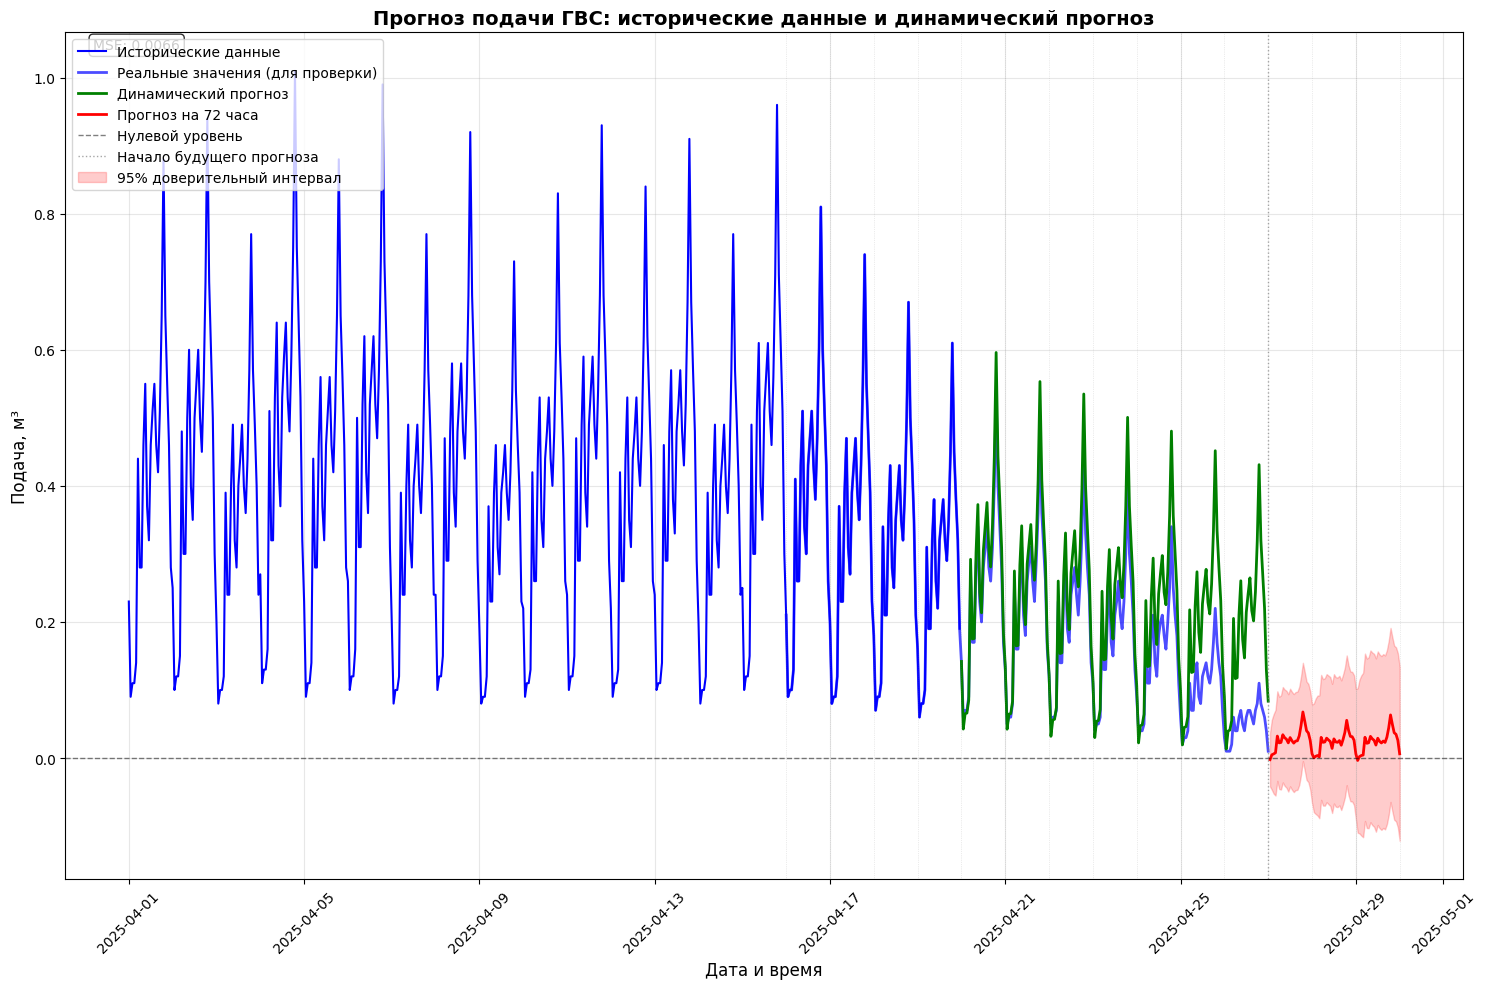


üìä –î–ï–¢–ê–õ–ò –ü–†–û–ì–ù–û–ó–ê:
   ‚Ä¢ –ü–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 2025-04-16 00:00:00 - 2025-04-27 00:00:00
   ‚Ä¢ –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞: 2025-04-20 00:00:00
   ‚Ä¢ –ë—É–¥—É—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑: 2025-04-27 01:00:00 - 2025-04-30 00:00:00
   ‚Ä¢ MSE: 0.0066

üìà –ü–ï–†–í–´–ï 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê:
   2025-04-27 01:00: -0.002 –º¬≥
   2025-04-27 02:00: 0.005 –º¬≥
   2025-04-27 03:00: 0.006 –º¬≥
   2025-04-27 04:00: 0.008 –º¬≥
   2025-04-27 05:00: 0.032 –º¬≥
   2025-04-27 06:00: 0.022 –º¬≥
   2025-04-27 07:00: 0.023 –º¬≥
   2025-04-27 08:00: 0.034 –º¬≥
   2025-04-27 09:00: 0.030 –º¬≥
   2025-04-27 10:00: 0.028 –º¬≥


In [ ]:
# –ü–û–°–¢–†–û–ï–ù–ò–ï –ì–†–ê–§–ò–ö–ê
plt.figure(figsize=(15, 10))

# 1. –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–ï –î–ê–ù–ù–´–ï (–¥–æ –Ω–∞—á–∞–ª–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞)
historical_data = gvs_time_series[:'2025-04-19 23:00:00']['–ü–æ–¥–∞—á–∞, –º3']
plt.plot(historical_data.index, historical_data, 
         label='–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ', color='blue', linewidth=1.5)

# 2. –†–ï–ê–õ–¨–ù–´–ï –ó–ù–ê–ß–ï–ù–ò–Ø (–ø–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏)
plt.plot(actual_values.index, actual_values, 
         label='–†–µ–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è (–¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏)', color='blue', linewidth=2, alpha=0.7)

# 3. –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô –ü–†–û–ì–ù–û–ó –ù–ê –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–• –î–ê–ù–ù–´–•
plt.plot(dynamic_pred_values_gvs_podacha.index, dynamic_pred_values_gvs_podacha, 
         label='–î–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –ø—Ä–æ–≥–Ω–æ–∑', color='green', linewidth=2, linestyle='-')

# 4. –ü–†–û–ì–ù–û–ó –ù–ê –ë–£–î–£–©–ï–ï
future_dates = pd.date_range(start=actual_values.index[-1] + pd.Timedelta(hours=1), 
                            periods=72, freq='H')
plt.plot(future_dates, dynamic_forecast_values_gvs_podacha, 
         label='–ü—Ä–æ–≥–Ω–æ–∑ –Ω–∞ 72 —á–∞—Å–∞', color='red', linewidth=2)

# 5. –ù–£–õ–ï–í–ê–Ø –õ–ò–ù–ò–Ø
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='–ù—É–ª–µ–≤–æ–π —É—Ä–æ–≤–µ–Ω—å')

# 6. –õ–ò–ù–ò–Ø –†–ê–ó–î–ï–õ–ï–ù–ò–Ø –ú–ï–ñ–î–£ –ò–°–¢–û–†–ò–ï–ô –ò –ü–†–û–ì–ù–û–ó–û–ú
split_date = actual_values.index[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1, alpha=0.7, 
           label='–ù–∞—á–∞–ª–æ –±—É–¥—É—â–µ–≥–æ –ø—Ä–æ–≥–Ω–æ–∑–∞')

# 7. –û–ë–õ–ê–°–¢–¨ –î–û–í–ï–†–ò–¢–ï–õ–¨–ù–û–ì–û –ò–ù–¢–ï–†–í–ê–õ–ê (–µ—Å–ª–∏ –µ—Å—Ç—å)
try:
    conf_int = dynamic_forecast_gvs_podacha.conf_int()
    plt.fill_between(future_dates, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='red', alpha=0.2, 
                    label='95% –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª')
except:
    print("–î–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–µ –∏–Ω—Ç–µ—Ä–≤–∞–ª—ã –Ω–µ–¥–æ—Å—Ç—É–ø–Ω—ã")

# –ù–ê–°–¢–†–û–ô–ö–ê –ì–†–ê–§–ò–ö–ê
plt.title('–ü—Ä–æ–≥–Ω–æ–∑ –ø–æ–¥–∞—á–∏ –ì–í–°: –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ –∏ –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –ø—Ä–æ–≥–Ω–æ–∑', 
          fontsize=14, fontweight='bold')
plt.xlabel('–î–∞—Ç–∞ –∏ –≤—Ä–µ–º—è', fontsize=12)
plt.ylabel('–ü–æ–¥–∞—á–∞, –º¬≥', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# –í–ï–†–¢–ò–ö–ê–õ–¨–ù–´–ï –õ–ò–ù–ò–ò –î–õ–Ø –†–ê–ó–î–ï–õ–ï–ù–ò–Ø –°–£–¢–û–ö
for date in pd.date_range(start='2025-04-16', end=future_dates[-1], freq='D'):
    plt.axvline(x=date, color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# –î–û–ë–ê–í–õ–ï–ù–ò–ï –¢–ï–ö–°–¢–û–í–û–ô –ò–ù–§–û–†–ú–ê–¶–ò–ò –ù–ê –ì–†–ê–§–ò–ö
plt.text(0.02, 0.98, f'MSE: {dyn_pred_gvs_podacha_mse:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()


# –î–û–ü–û–õ–ù–ò–¢–ï–õ–¨–ù–ê–Ø –ò–ù–§–û–†–ú–ê–¶–ò–Ø
print(f"\nüìä –î–ï–¢–ê–õ–ò –ü–†–û–ì–ù–û–ó–ê:")
print(f"   ‚Ä¢ –ü–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {actual_values.index[0]} - {actual_values.index[-1]}")
print(f"   ‚Ä¢ –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞: {dynamic_pred_values_gvs_podacha.index[0]}")
print(f"   ‚Ä¢ –ë—É–¥—É—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑: {future_dates[0]} - {future_dates[-1]}")
print(f"   ‚Ä¢ MSE: {dyn_pred_gvs_podacha_mse:.4f}")

# –í–´–í–û–î –ü–ï–†–í–´–• 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê
print(f"\nüìà –ü–ï–†–í–´–ï 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê:")
for i, (date, value) in enumerate(zip(future_dates[:10], dynamic_forecast_values_gvs_podacha[:10])):
    print(f"   {date.strftime('%Y-%m-%d %H:%M')}: {value:.3f} –º¬≥")

## –ì–í–° –û–±—Ä–∞—Ç–∫–∞

In [42]:
# –ê–Ω–∞–ª–æ–≥–∏—á–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è —Å –æ–±—É—á–µ–Ω–∏–µ–º –º–æ–¥–µ–ª–∏ –¥–ª—è –ü–æ–¥–∞—á–∏
SARIMAX_model_gvs_obratka = pm.auto_arima(gvs_time_series[['–û–±—Ä–∞—Ç–∫–∞, –º3']], exogenous=gvs_time_series[['hour_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

KeyboardInterrupt: 

In [ ]:
SARIMAX_model_gvs_obratka.summary()

In [ ]:
# –ê–Ω–∞–ª–æ–≥–∏—á–Ω—ã–µ –¥–µ–π—Å—Ç–≤–∏—è —Å –æ–±—É—á–µ–Ω–∏–µ–º –º–æ–¥–µ–ª–∏ –¥–ª—è –ü–æ–¥–∞—á–∏
model_gvs_obratka = SARIMAX(gvs_time_series['–û–±—Ä–∞—Ç–∫–∞, –º3'], 
                order = (1, 0, 0), 
                seasonal_order =(1, 1, [1, 2], 24))

result2 = model_gvs_obratka.fit()
result2.summary()

In [ ]:
import pickle

# –°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å —Å–æ –≤—Å–µ–π –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–µ–π
model_package = {
    'model': result2,
    'model_type': 'SARIMAX',
    'order': (1, 0, 0),
    'seasonal_order': (2, 1, 1, 24),
    'training_data_info': {
        'series_name': '–û–±—Ä–∞—Ç–∫–∞, –º3',
        'data_length': len(gvs_time_series),
        'last_date': gvs_time_series.index[-1] if hasattr(gvs_time_series.index, '[-1]') else None
    },
    'fit_date': pd.Timestamp.now()
}

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –ø–æ–ª–Ω—ã–π –ø–∞–∫–µ—Ç
with open('sarimax_model_gvs_obratka.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("–ü–æ–ª–Ω—ã–π –ø–∞–∫–µ—Ç –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ sarimax_model_gvs_obratka.pkl")

In [40]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –∏–∑ pickle —Ñ–∞–π–ª–∞
with open('sarimax_model_gvs_obratka.pkl', 'rb') as f:
    loaded_package = pickle.load(f)

# –ò–∑–≤–ª–µ–∫–∞–µ–º –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã –∏–∑ –ø–∞–∫–µ—Ç–∞
model_gvs_obratka = loaded_package['model']
model_type = loaded_package['model_type']
order = loaded_package['order']
seasonal_order = loaded_package['seasonal_order']
training_info = loaded_package['training_data_info']
fit_date = loaded_package['fit_date']

print("–ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!")
print(f"–¢–∏–ø –º–æ–¥–µ–ª–∏: {model_type}")
print(f"Order: {order}")
print(f"Seasonal order: {seasonal_order}")
print(f"–î–∞—Ç–∞ –æ–±—É—á–µ–Ω–∏—è: {fit_date}")
print(f"–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {training_info}")

–ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!
–¢–∏–ø –º–æ–¥–µ–ª–∏: SARIMAX
Order: (1, 0, 0)
Seasonal order: (2, 1, 1, 24)
–î–∞—Ç–∞ –æ–±—É—á–µ–Ω–∏—è: 2025-10-01 23:34:43.044294
–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {'series_name': '–û–±—Ä–∞—Ç–∫–∞, –º3', 'data_length': 625, 'last_date': None}


In [41]:
# –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô –ü–†–û–ì–ù–û–ó –ù–ê –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–• –î–ê–ù–ù–´–• (–Ω–∞—á–∏–Ω–∞—è —Å 20 –∞–ø—Ä–µ–ª—è)
dyn_pred_gvs_obratka = model_gvs_obratka.get_prediction(
    start=pd.to_datetime('2025-04-20 00:00:00'),  # –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞
    dynamic=True  # –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô —Ä–µ–∂–∏–º: –∫–∞–∂–¥—ã–π —Å–ª–µ–¥—É—é—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç –ø—Ä–µ–¥—ã–¥—É—â–∏–µ –ø—Ä–æ–≥–Ω–æ–∑—ã
) 
# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
dynamic_pred_values_gvs_obratka = dyn_pred_gvs_obratka.predicted_mean

# –§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è (—Å 16 –∞–ø—Ä–µ–ª—è –¥–ª—è –±–æ–ª–µ–µ –¥–ª–∏–Ω–Ω–æ–≥–æ –ø–µ—Ä–∏–æ–¥–∞)
actual_values = gvs_time_series['2025-04-16 00:00:00':]['–û–±—Ä–∞—Ç–∫–∞, –º3']

# –í–´–ß–ò–°–õ–ï–ù–ò–ï –°–†–ï–î–ù–ï–ö–í–ê–î–†–ê–¢–ò–ß–ù–û–ô –û–®–ò–ë–ö–ò (MSE)
dyn_pred_gvs_obratka_mse = ((dynamic_pred_values_gvs_obratka - actual_values) ** 2).mean()
print('–°—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç {}'.format(round(dyn_pred_gvs_obratka_mse, 2)))

# –ü–†–û–ì–ù–û–ó –ù–ê –ë–£–î–£–©–ï–ï (72 —á–∞—Å–∞ = 3 —Å—É—Ç–æ–∫)
dynamic_forecast_gvs_obratka = model_gvs_obratka.get_forecast(steps=72)
dynamic_forecast_values_gvs_obratka = dynamic_forecast_gvs_obratka.predicted_mean

–°—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç 0.01


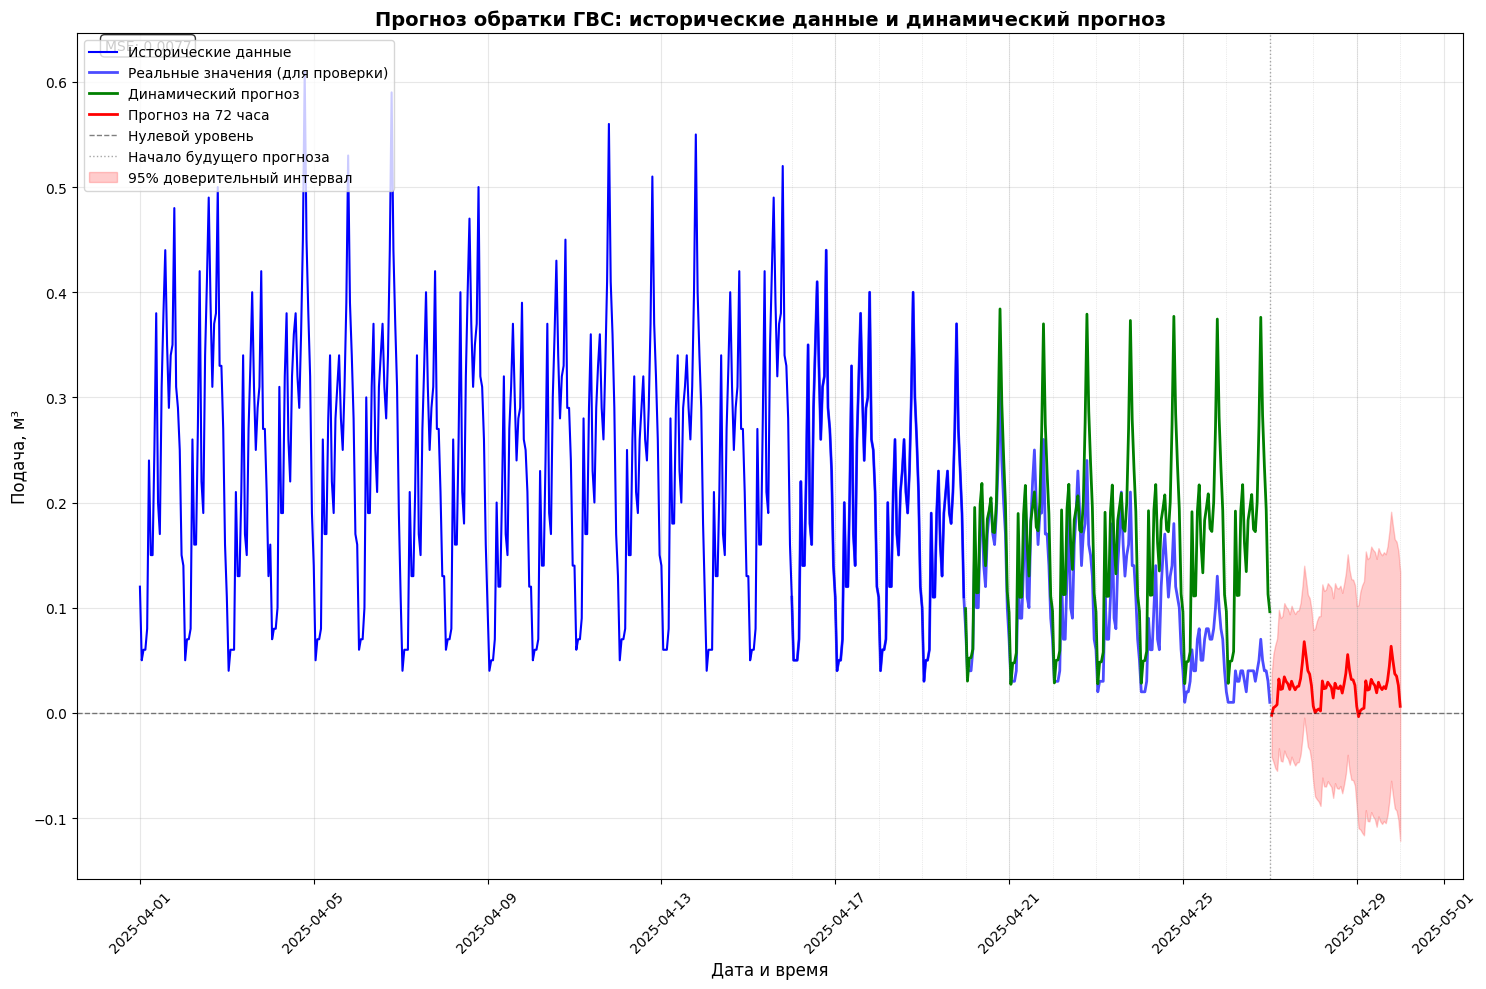


üìä –î–ï–¢–ê–õ–ò –ü–†–û–ì–ù–û–ó–ê:
   ‚Ä¢ –ü–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 2025-04-16 00:00:00 - 2025-04-27 00:00:00
   ‚Ä¢ –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞: 2025-04-20 00:00:00
   ‚Ä¢ –ë—É–¥—É—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑: 2025-04-27 01:00:00 - 2025-04-30 00:00:00
   ‚Ä¢ MSE: 0.0077

üìà –ü–ï–†–í–´–ï 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê:
   2025-04-27 01:00: -0.002 –º¬≥
   2025-04-27 02:00: 0.005 –º¬≥
   2025-04-27 03:00: 0.006 –º¬≥
   2025-04-27 04:00: 0.008 –º¬≥
   2025-04-27 05:00: 0.032 –º¬≥
   2025-04-27 06:00: 0.022 –º¬≥
   2025-04-27 07:00: 0.023 –º¬≥
   2025-04-27 08:00: 0.034 –º¬≥
   2025-04-27 09:00: 0.030 –º¬≥
   2025-04-27 10:00: 0.028 –º¬≥


In [42]:
# –ü–û–°–¢–†–û–ï–ù–ò–ï –ì–†–ê–§–ò–ö–ê
plt.figure(figsize=(15, 10))

# 1. –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–ï –î–ê–ù–ù–´–ï (–¥–æ –Ω–∞—á–∞–ª–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞)
historical_data = gvs_time_series[:'2025-04-19 23:00:00']['–û–±—Ä–∞—Ç–∫–∞, –º3']
plt.plot(historical_data.index, historical_data, 
         label='–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ', color='blue', linewidth=1.5)

# 2. –†–ï–ê–õ–¨–ù–´–ï –ó–ù–ê–ß–ï–ù–ò–Ø (–ø–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏)
plt.plot(actual_values.index, actual_values, 
         label='–†–µ–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è (–¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏)', color='blue', linewidth=2, alpha=0.7)

# 3. –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô –ü–†–û–ì–ù–û–ó –ù–ê –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–• –î–ê–ù–ù–´–•
plt.plot(dynamic_pred_values_gvs_obratka.index, dynamic_pred_values_gvs_obratka, 
         label='–î–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –ø—Ä–æ–≥–Ω–æ–∑', color='green', linewidth=2, linestyle='-')

# 4. –ü–†–û–ì–ù–û–ó –ù–ê –ë–£–î–£–©–ï–ï
future_dates = pd.date_range(start=actual_values.index[-1] + pd.Timedelta(hours=1), 
                            periods=72, freq='H')
plt.plot(future_dates, dynamic_forecast_values_gvs_obratka, 
         label='–ü—Ä–æ–≥–Ω–æ–∑ –Ω–∞ 72 —á–∞—Å–∞', color='red', linewidth=2)

# 5. –ù–£–õ–ï–í–ê–Ø –õ–ò–ù–ò–Ø
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='–ù—É–ª–µ–≤–æ–π —É—Ä–æ–≤–µ–Ω—å')

# 6. –õ–ò–ù–ò–Ø –†–ê–ó–î–ï–õ–ï–ù–ò–Ø –ú–ï–ñ–î–£ –ò–°–¢–û–†–ò–ï–ô –ò –ü–†–û–ì–ù–û–ó–û–ú
split_date = actual_values.index[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1, alpha=0.7, 
           label='–ù–∞—á–∞–ª–æ –±—É–¥—É—â–µ–≥–æ –ø—Ä–æ–≥–Ω–æ–∑–∞')

# 7. –û–ë–õ–ê–°–¢–¨ –î–û–í–ï–†–ò–¢–ï–õ–¨–ù–û–ì–û –ò–ù–¢–ï–†–í–ê–õ–ê (–µ—Å–ª–∏ –µ—Å—Ç—å)
try:
    conf_int = dynamic_forecast_gvs_obratka.conf_int()
    plt.fill_between(future_dates, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='red', alpha=0.2, 
                    label='95% –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª')
except:
    print("–î–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–µ –∏–Ω—Ç–µ—Ä–≤–∞–ª—ã –Ω–µ–¥–æ—Å—Ç—É–ø–Ω—ã")

# –ù–ê–°–¢–†–û–ô–ö–ê –ì–†–ê–§–ò–ö–ê
plt.title('–ü—Ä–æ–≥–Ω–æ–∑ –æ–±—Ä–∞—Ç–∫–∏ –ì–í–°: –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ –∏ –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –ø—Ä–æ–≥–Ω–æ–∑', 
          fontsize=14, fontweight='bold')
plt.xlabel('–î–∞—Ç–∞ –∏ –≤—Ä–µ–º—è', fontsize=12)
plt.ylabel('–ü–æ–¥–∞—á–∞, –º¬≥', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# –í–ï–†–¢–ò–ö–ê–õ–¨–ù–´–ï –õ–ò–ù–ò–ò –î–õ–Ø –†–ê–ó–î–ï–õ–ï–ù–ò–Ø –°–£–¢–û–ö
for date in pd.date_range(start='2025-04-16', end=future_dates[-1], freq='D'):
    plt.axvline(x=date, color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# –î–û–ë–ê–í–õ–ï–ù–ò–ï –¢–ï–ö–°–¢–û–í–û–ô –ò–ù–§–û–†–ú–ê–¶–ò–ò –ù–ê –ì–†–ê–§–ò–ö
plt.text(0.02, 0.98, f'MSE: {dyn_pred_gvs_obratka_mse:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()


# –î–û–ü–û–õ–ù–ò–¢–ï–õ–¨–ù–ê–Ø –ò–ù–§–û–†–ú–ê–¶–ò–Ø
print(f"\nüìä –î–ï–¢–ê–õ–ò –ü–†–û–ì–ù–û–ó–ê:")
print(f"   ‚Ä¢ –ü–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {actual_values.index[0]} - {actual_values.index[-1]}")
print(f"   ‚Ä¢ –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞: {dynamic_pred_values_gvs_obratka.index[0]}")
print(f"   ‚Ä¢ –ë—É–¥—É—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑: {future_dates[0]} - {future_dates[-1]}")
print(f"   ‚Ä¢ MSE: {dyn_pred_gvs_obratka_mse:.4f}")

# –í–´–í–û–î –ü–ï–†–í–´–• 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê
print(f"\nüìà –ü–ï–†–í–´–ï 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê:")
for i, (date, value) in enumerate(zip(future_dates[:10], dynamic_forecast_values_gvs_obratka[:10])):
    print(f"   {date.strftime('%Y-%m-%d %H:%M')}: {value:.3f} –º¬≥")

## –•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ

In [20]:
SARIMAX_model_hvs_potreb = pm.auto_arima(gvs_time_series[['–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3']], exogenous=gvs_time_series[['hour_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

KeyboardInterrupt: 

In [ ]:
SARIMAX_model_hvs_potreb.summary()

In [ ]:
SARIMAX_model_hvs_potreb = SARIMAX(gvs_time_series['–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3'], 
                order = (1, 0, 2), 
                seasonal_order =(1, 1, 2, 24))

result3 = SARIMAX_model_hvs_potreb.fit()
result3.summary()

In [ ]:
model_package = {
    'model': result3,
    'model_type': 'SARIMAX',
    'order': (1, 0, 0),
    'seasonal_order': (2, 1, 1, 24),
    'training_data_info': {
        'series_name': '–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3',
        'data_length': len(gvs_time_series),
        'last_date': gvs_time_series.index[-1] if hasattr(gvs_time_series.index, '[-1]') else None
    },
    'fit_date': pd.Timestamp.now()
}

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –ø–æ–ª–Ω—ã–π –ø–∞–∫–µ—Ç
with open('sarimax_model_hvs_potreb.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("–ü–æ–ª–Ω—ã–π –ø–∞–∫–µ—Ç –º–æ–¥–µ–ª–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ sarimax_model_hvs_potreb.pkl")

In [21]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –∏–∑ pickle —Ñ–∞–π–ª–∞
with open('sarimax_model_hvs_potreb.pkl', 'rb') as f:
    loaded_package = pickle.load(f)

# –ò–∑–≤–ª–µ–∫–∞–µ–º –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã –∏–∑ –ø–∞–∫–µ—Ç–∞
model_hvs_potreb = loaded_package['model']
model_type = loaded_package['model_type']
order = loaded_package['order']
seasonal_order = loaded_package['seasonal_order']
training_info = loaded_package['training_data_info']
fit_date = loaded_package['fit_date']

print("–ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!")
print(f"–¢–∏–ø –º–æ–¥–µ–ª–∏: {model_type}")
print(f"Order: {order}")
print(f"Seasonal order: {seasonal_order}")
print(f"–î–∞—Ç–∞ –æ–±—É—á–µ–Ω–∏—è: {fit_date}")
print(f"–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {training_info}")

–ú–æ–¥–µ–ª—å —É—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω–∞!
–¢–∏–ø –º–æ–¥–µ–ª–∏: SARIMAX
Order: (1, 0, 0)
Seasonal order: (2, 1, 1, 24)
–î–∞—Ç–∞ –æ–±—É—á–µ–Ω–∏—è: 2025-10-02 21:48:46.712824
–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö: {'series_name': '–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3', 'data_length': 625, 'last_date': None}


In [22]:
# –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô –ü–†–û–ì–ù–û–ó –ù–ê –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–• –î–ê–ù–ù–´–• (–Ω–∞—á–∏–Ω–∞—è —Å 20 –∞–ø—Ä–µ–ª—è)
dyn_pred_hvs_potreb = model_hvs_potreb.get_prediction(
    start=pd.to_datetime('2025-04-20 00:00:00'),  # –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞
    dynamic=True  # –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô —Ä–µ–∂–∏–º: –∫–∞–∂–¥—ã–π —Å–ª–µ–¥—É—é—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç –ø—Ä–µ–¥—ã–¥—É—â–∏–µ –ø—Ä–æ–≥–Ω–æ–∑—ã
) 
# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
dynamic_pred_values_hvs_potreb = dyn_pred_hvs_potreb.predicted_mean

# –§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è (—Å 16 –∞–ø—Ä–µ–ª—è –¥–ª—è –±–æ–ª–µ–µ –¥–ª–∏–Ω–Ω–æ–≥–æ –ø–µ—Ä–∏–æ–¥–∞)
actual_values = gvs_time_series['2025-04-16 00:00:00':]['–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3']

# –í–´–ß–ò–°–õ–ï–ù–ò–ï –°–†–ï–î–ù–ï–ö–í–ê–î–†–ê–¢–ò–ß–ù–û–ô –û–®–ò–ë–ö–ò (MSE)
dyn_pred_hvs_potreb_mse = ((dynamic_pred_values_hvs_potreb - actual_values) ** 2).mean()
print('–°—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç {}'.format(round(dyn_pred_hvs_potreb_mse, 2)))

# –ü–†–û–ì–ù–û–ó –ù–ê –ë–£–î–£–©–ï–ï (72 —á–∞—Å–∞ = 3 —Å—É—Ç–æ–∫)
dynamic_forecast_hvs_potreb = model_hvs_potreb.get_forecast(steps=72)
dynamic_forecast_values_hvs_potreb = dynamic_forecast_hvs_potreb.predicted_mean

–°—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç 0.0


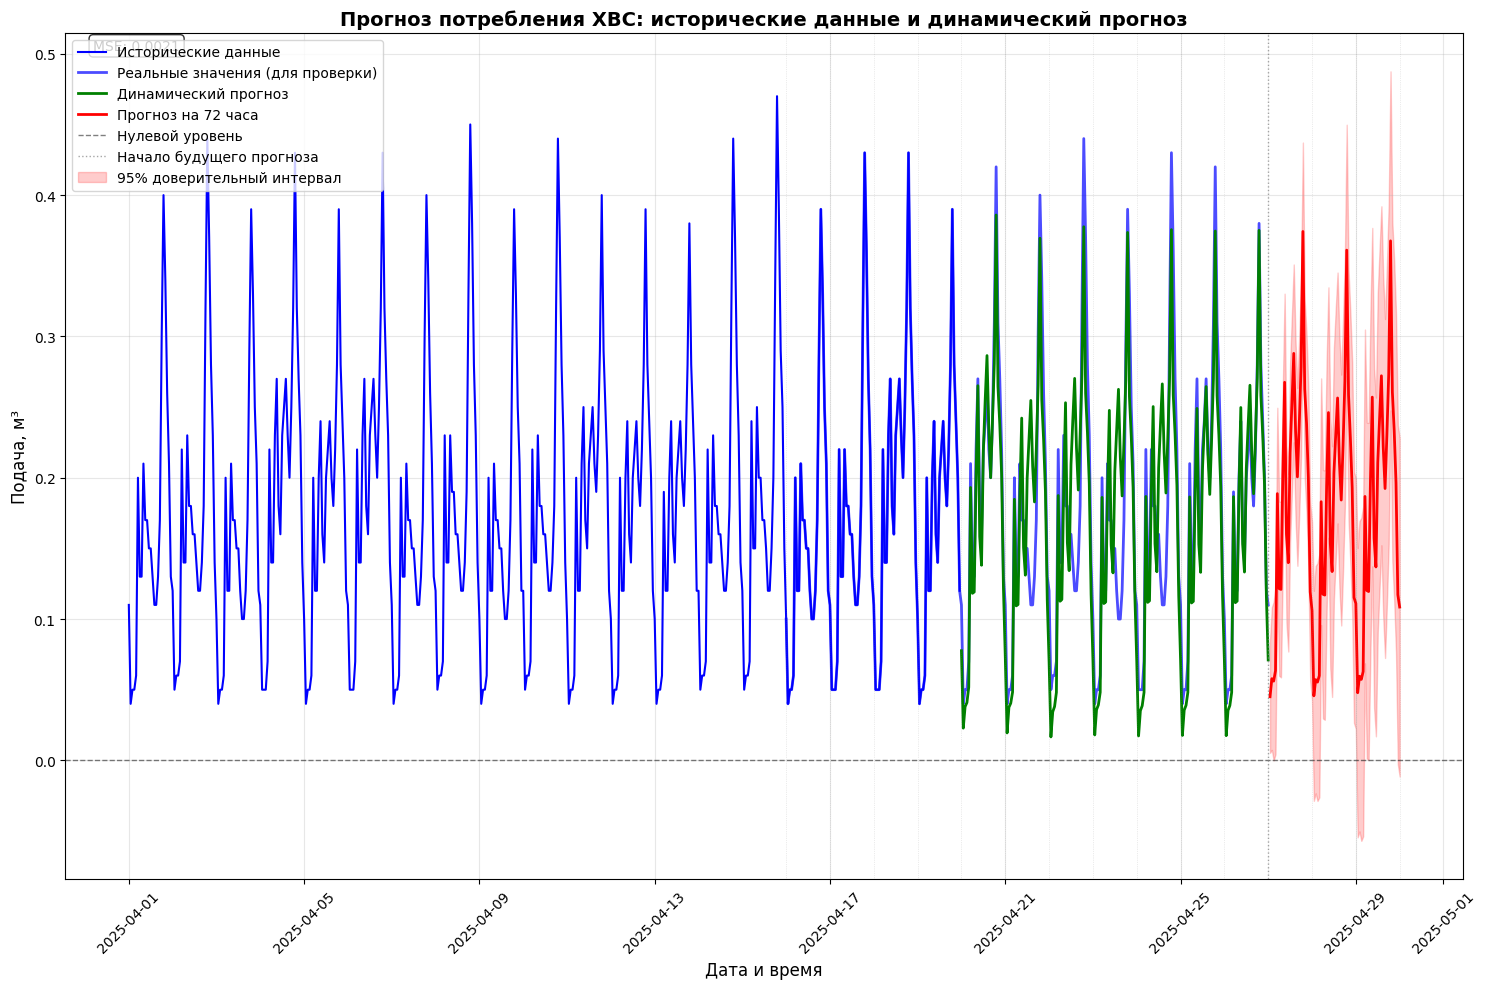


üìä –î–ï–¢–ê–õ–ò –ü–†–û–ì–ù–û–ó–ê:
   ‚Ä¢ –ü–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 2025-04-16 00:00:00 - 2025-04-27 00:00:00
   ‚Ä¢ –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞: 2025-04-20 00:00:00
   ‚Ä¢ –ë—É–¥—É—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑: 2025-04-27 01:00:00 - 2025-04-30 00:00:00
   ‚Ä¢ MSE: 0.0021

üìà –ü–ï–†–í–´–ï 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê:
   2025-04-27 01:00: 0.045 –º¬≥
   2025-04-27 02:00: 0.058 –º¬≥
   2025-04-27 03:00: 0.056 –º¬≥
   2025-04-27 04:00: 0.063 –º¬≥
   2025-04-27 05:00: 0.189 –º¬≥
   2025-04-27 06:00: 0.122 –º¬≥
   2025-04-27 07:00: 0.121 –º¬≥
   2025-04-27 08:00: 0.201 –º¬≥
   2025-04-27 09:00: 0.268 –º¬≥
   2025-04-27 10:00: 0.160 –º¬≥


In [23]:
# –ü–û–°–¢–†–û–ï–ù–ò–ï –ì–†–ê–§–ò–ö–ê
plt.figure(figsize=(15, 10))

# 1. –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–ï –î–ê–ù–ù–´–ï (–¥–æ –Ω–∞—á–∞–ª–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞)
historical_data = gvs_time_series[:'2025-04-19 23:00:00']['–•–í–° –ü–æ—Ç—Ä–µ–±–ª–µ–Ω–∏–µ –∑–∞ –ø–µ—Ä–∏–æ–¥, –º3']
plt.plot(historical_data.index, historical_data, 
         label='–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ', color='blue', linewidth=1.5)

# 2. –†–ï–ê–õ–¨–ù–´–ï –ó–ù–ê–ß–ï–ù–ò–Ø (–ø–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏)
plt.plot(actual_values.index, actual_values, 
         label='–†–µ–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è (–¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏)', color='blue', linewidth=2, alpha=0.7)

# 3. –î–ò–ù–ê–ú–ò–ß–ï–°–ö–ò–ô –ü–†–û–ì–ù–û–ó –ù–ê –ò–°–¢–û–†–ò–ß–ï–°–ö–ò–• –î–ê–ù–ù–´–•
plt.plot(dynamic_pred_values_hvs_potreb.index, dynamic_pred_values_hvs_potreb, 
         label='–î–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –ø—Ä–æ–≥–Ω–æ–∑', color='green', linewidth=2)

# 4. –ü–†–û–ì–ù–û–ó –ù–ê –ë–£–î–£–©–ï–ï
future_dates = pd.date_range(start=actual_values.index[-1] + pd.Timedelta(hours=1), 
                            periods=72, freq='H')
plt.plot(future_dates, dynamic_forecast_values_hvs_potreb, 
         label='–ü—Ä–æ–≥–Ω–æ–∑ –Ω–∞ 72 —á–∞—Å–∞', color='red', linewidth=2)

# 5. –ù–£–õ–ï–í–ê–Ø –õ–ò–ù–ò–Ø
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='–ù—É–ª–µ–≤–æ–π —É—Ä–æ–≤–µ–Ω—å')

# 6. –õ–ò–ù–ò–Ø –†–ê–ó–î–ï–õ–ï–ù–ò–Ø –ú–ï–ñ–î–£ –ò–°–¢–û–†–ò–ï–ô –ò –ü–†–û–ì–ù–û–ó–û–ú
split_date = actual_values.index[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1, alpha=0.7, 
           label='–ù–∞—á–∞–ª–æ –±—É–¥—É—â–µ–≥–æ –ø—Ä–æ–≥–Ω–æ–∑–∞')

# 7. –û–ë–õ–ê–°–¢–¨ –î–û–í–ï–†–ò–¢–ï–õ–¨–ù–û–ì–û –ò–ù–¢–ï–†–í–ê–õ–ê (–µ—Å–ª–∏ –µ—Å—Ç—å)
try:
    conf_int = dynamic_forecast_hvs_potreb.conf_int()
    plt.fill_between(future_dates, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='red', alpha=0.2, 
                    label='95% –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª')
except:
    print("–î–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–µ –∏–Ω—Ç–µ—Ä–≤–∞–ª—ã –Ω–µ–¥–æ—Å—Ç—É–ø–Ω—ã")

# –ù–ê–°–¢–†–û–ô–ö–ê –ì–†–ê–§–ò–ö–ê
plt.title('–ü—Ä–æ–≥–Ω–æ–∑ –ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è –•–í–°: –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ –∏ –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–π –ø—Ä–æ–≥–Ω–æ–∑', 
          fontsize=14, fontweight='bold')
plt.xlabel('–î–∞—Ç–∞ –∏ –≤—Ä–µ–º—è', fontsize=12)
plt.ylabel('–ü–æ–¥–∞—á–∞, –º¬≥', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# –í–ï–†–¢–ò–ö–ê–õ–¨–ù–´–ï –õ–ò–ù–ò–ò –î–õ–Ø –†–ê–ó–î–ï–õ–ï–ù–ò–Ø –°–£–¢–û–ö
for date in pd.date_range(start='2025-04-16', end=future_dates[-1], freq='D'):
    plt.axvline(x=date, color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# –î–û–ë–ê–í–õ–ï–ù–ò–ï –¢–ï–ö–°–¢–û–í–û–ô –ò–ù–§–û–†–ú–ê–¶–ò–ò –ù–ê –ì–†–ê–§–ò–ö
plt.text(0.02, 0.98, f'MSE: {dyn_pred_hvs_potreb_mse:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()


# –î–û–ü–û–õ–ù–ò–¢–ï–õ–¨–ù–ê–Ø –ò–ù–§–û–†–ú–ê–¶–ò–Ø
print(f"\nüìä –î–ï–¢–ê–õ–ò –ü–†–û–ì–ù–û–ó–ê:")
print(f"   ‚Ä¢ –ü–µ—Ä–∏–æ–¥ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {actual_values.index[0]} - {actual_values.index[-1]}")
print(f"   ‚Ä¢ –ù–∞—á–∞–ª–æ –ø—Ä–æ–≥–Ω–æ–∑–∞: {dynamic_pred_values_hvs_potreb.index[0]}")
print(f"   ‚Ä¢ –ë—É–¥—É—â–∏–π –ø—Ä–æ–≥–Ω–æ–∑: {future_dates[0]} - {future_dates[-1]}")
print(f"   ‚Ä¢ MSE: {dyn_pred_hvs_potreb_mse:.4f}")

# –í–´–í–û–î –ü–ï–†–í–´–• 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê
print(f"\nüìà –ü–ï–†–í–´–ï 10 –ó–ù–ê–ß–ï–ù–ò–ô –ü–†–û–ì–ù–û–ó–ê:")
for i, (date, value) in enumerate(zip(future_dates[:10], dynamic_forecast_values_hvs_potreb[:10])):
    print(f"   {date.strftime('%Y-%m-%d %H:%M')}: {value:.3f} –º¬≥")